In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import torch
from torch.distributions import *
from scipy.special import beta as B
from scipy.special import gamma as Gam
from scipy.special import digamma

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks
     time  sunspot.year
0  1700.5           8.3
1  1701.5          18.3
2  1702.5          26.7
3  1703.5          38.3
4  1704.5          60.0
(319,)


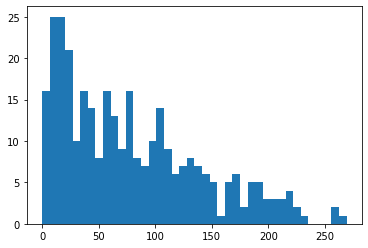

In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd My\ Drive
%cd Colab\ Notebooks

df = pd.read_csv('sunspot.csv', sep=';', names=['time', 'sunspot.year'], usecols=[0, 1])
print (df.head())
plt.hist(df['sunspot.year'].values, bins=40)

data = df['sunspot.year'].values
print (data.shape)

In [0]:
def mixture_weights(v):
    res = torch.cat([ torch.tensor([1], dtype=torch.float32), torch.cumprod((1 - v)[:-1], dim=0)])
    return v * res

# This is a visual aid; doesn't actually work
def model(data):
  v = []
  eta = []
  G_0 = Gamma(3, 0.04) # hyperparameters
  alpha = 1.2 # hyperparameter
  for i in range(np.infty): # infinitely many mixtures
    v.append(Beta(1, alpha).sample())
    eta.append(G_0.sample())
  
  z = []
  for n in range(len(data)):
    z.append(Categorical(mixture_weights(v)).sample())
    x.append(Poisson(eta[z[n]]).sample())

In [0]:
test = torch.arange(1, 17).reshape(4, 4).type(torch.float)

print (test)

# print (test[:, 2:])

# print (test[:, 2:].sum(axis = 1))

# print (test[1, :])

# print (test.mean(axis=0))

print ([1,2,3][:2])

print (test.max())

test = torch.tensor([1, 1, 1, 5, 5, 5, 3, 10])

print (test)

if not test[8]:
  print (test[4])

_, un = test.unique(return_counts=True)

# print (un)

tensor([[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.]])
[1, 2]
tensor(16.)
tensor([ 1,  1,  1,  5,  5,  5,  3, 10])


IndexError: ignored

In [0]:
# Inference

# Gamma prior on the rates (G_0 is a Gamma with params lambda_0, lambda_1)

def z_init(N, alpha):
    '''
    Initializes a random vector of cluster assignments
    '''
    z = torch.zeros(N)
    counts = [1] 
    for i in range(1, N):
        weights = torch.tensor([count / (i+alpha) for count in counts] + [alpha / (i+alpha)])
        new_z = Categorical(weights).sample()
        z[i] = new_z
        if new_z > len(counts) - 1:
          counts.append(1)
        else:
          counts[new_z] += 1
    
    return z

def z_conditional(Z, alpha):
    '''
    Input:
      Z - (t,) tensor consisting of the past t many cluster assignments (should it contain all cluster assignments aside from the current one?)
      alpha - scaling hyperparameter
    '''

    K = Z.max() # total number of clusters (at current step)
    N = Z.shape[0]
    _, counts = Z.unique(return_counts=True)
    weights = torch.tensor([count / (N+alpha) for count in counts] + [alpha / (N+alpha)])
    return Categorical(weights).sample()

# def eta_conditional(Z, X, k, lmbda):
#     '''
#     Input:
#       Z - (N,) tensor consisting of all cluster assignments
#       X - (N,) tensor consisting of all observations
#       k - the number of the cluster for which we are sampling cluster parameters
#       lbmda - (2,) tensor of Gamma hyperparameters
#     '''

#     N = Z.shape[0]
#     cluster_obs = [X[i] for i in range(N) if Z[i] == k]
#     return Gamma(lmbda[0] + sum(cluster_obs), lmbda[1] + len(cluster_obs)).sample()

def eta_conditional(Z, X, k, lmbda):
    N = Z.shape[0]
    cluster_obs = [X[i] for i in range(N) if Z[i] == k]
    mu = (1/((1/lmbda[1]) + len(cluster_obs))) * ((lmbda[0] / lmbda[1]**2) + sum(cluster_obs))
    return Normal(mu, 1).sample()



alpha = torch.tensor([1.2])
# lmbda = torch.tensor([1.2, 0.005])
# lmbda = torch.tensor([1., 2.])
lmbda = torch.tensor([0., 50.])

N = data.shape[0]
X = torch.tensor(data, dtype=torch.float)

num_iter = 1000

z = z_init(N, alpha)
# eta = Gamma(lmbda[0], lmbda[1]).sample([int(z.max().item())])
eta = Normal(lmbda[0], lmbda[1]).sample([int(z.max().item())])


z_t = []
eta_t = []
for iteration in range(num_iter):
    z_new = torch.zeros(N)
    z_new[0] = 0
    
    for i in range(1, N):
        z_new[i] = z_conditional(z[:i], alpha) 
    
    K = int(z_new.max().item()) + 1
    eta_new = torch.zeros(K)
    
    for j in range(K):
        eta_new[j] = eta_conditional(z_new, X, j, lmbda)

    z_t.append(z_new)
    eta_t.append(eta_new)

    z = z_new
    eta = eta_new


In [9]:
def get_weights(Z, alpha):
    N = Z.shape[0]
    _, counts = Z.unique(return_counts=True)
    weights = torch.tensor([count / (N+alpha) for count in counts])
    return weights / weights.sum()

for i in range(100, len(z_t), 50):
    print (get_weights(z_t[i], alpha))
    print (eta_t[i])


max_clusters = int(torch.tensor([len(eta_i) for eta_i in eta_t]).max())

Bayes_Weights = torch.zeros(max_clusters)
Bayes_Rates = torch.zeros(max_clusters)

Bayes_Weights = get_weights(z_t[-1], alpha)
Bayes_Rates = eta_t[-1]



tensor([0.4232, 0.2038, 0.1285, 0.1317, 0.0596, 0.0188, 0.0188, 0.0094, 0.0031,
        0.0031])
tensor([76.0555, 81.1894, 79.5095, 73.2435, 78.2660, 88.5173, 96.8057, 89.2001,
         8.7442, 27.4009])
tensor([0.4514, 0.3041, 0.1536, 0.0627, 0.0219, 0.0063])
tensor([77.1105, 79.8203, 76.4291, 95.6872, 65.7974, 79.2128])
tensor([0.4734, 0.1661, 0.1505, 0.1254, 0.0408, 0.0157, 0.0188, 0.0094])
tensor([ 80.2542,  77.4494,  70.8447,  78.3381,  95.1651,  51.6858,  73.5040,
          0.5409, 132.6741])
tensor([0.3103, 0.4545, 0.1411, 0.0690, 0.0251])
tensor([84.7999, 75.6907, 76.2547, 68.0768, 80.8419])
tensor([0.4577, 0.2665, 0.0878, 0.1191, 0.0376, 0.0188, 0.0094, 0.0031])
tensor([ 76.9990,  85.9811,  59.5920,  90.1339,  57.2772,  39.6771,  35.2747,
        214.0443])
tensor([0.2571, 0.3636, 0.2445, 0.0721, 0.0345, 0.0125, 0.0031, 0.0031, 0.0063,
        0.0031])
tensor([ 78.8222,  81.3128,  76.9935,  67.3974,  71.3578, 118.1175,  45.0333,
        166.6150,  78.4215,  16.8078])
tensor([0

In [11]:

# for i in range(100, len(z_t), 50):
#     print (get_weights(z_t[i], alpha))
#     print (eta_t[i])


print (Bayes_Weights)
print (Bayes_Rates)

print(X)

tensor([0.4734, 0.3260, 0.1003, 0.0815, 0.0188])
tensor([80.1083, 81.7539, 87.5937, 54.2715, 52.2217])
tensor([  8.3000,  18.3000,  26.7000,  38.3000,  60.0000,  96.7000,  48.3000,
         33.3000,  16.7000,  13.3000,   5.0000,   0.0000,   0.0000,   3.3000,
         18.3000,  45.0000,  78.3000, 105.0000, 100.0000,  65.0000,  46.7000,
         43.3000,  36.7000,  18.3000,  35.0000,  66.7000, 130.0000, 203.3000,
        171.7000, 121.7000,  78.3000,  58.3000,  18.3000,   8.3000,  26.7000,
         56.7000, 116.7000, 135.0000, 185.0000, 168.3000, 121.7000,  66.7000,
         33.3000,  26.7000,   8.3000,  18.3000,  36.7000,  66.7000, 100.0000,
        134.8000, 139.0000,  79.5000,  79.7000,  51.2000,  20.3000,  16.0000,
         17.0000,  54.0000,  79.3000,  90.0000, 104.8000, 143.2000, 102.0000,
         75.2000,  60.7000,  34.8000,  19.0000,  63.0000, 116.3000, 176.8000,
        168.0000, 136.0000, 110.8000,  58.0000,  51.0000,  11.7000,  33.0000,
        154.2000, 257.3000, 209.8000, 1

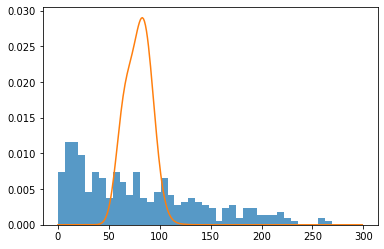

In [7]:
Samples = torch.arange(0, 300).type(torch.float)

def mix_of_Poisson(weights, rates, samples):
  return sum( [weights[i] * np.exp(Poisson(rates[i]).log_prob(samples)) for i in range(len(weights))] )


Y = mix_of_Poisson(Bayes_Weights, Bayes_Rates, Samples)
plt.hist(X, bins=40, density=True, lw=0, alpha=0.75);
plt.plot(Samples, Y)
plt.show()